# Efficient Pandas
### A guide for using pandas efficiently

In this guide, we will cover some important pandas topics that will make your life easier, and your code run faster.

This guide assumes you already know how to use pandas on a basic level, and are willing to take it to the next step.

Much of this guide is taken / inspired by [Chip Huyen's just-pandas-things guide](https://github.com/chiphuyen/just-pandas-things), the rest is from other blog posts / my own experience.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("data/interviews.csv")

print(df.shape)
df.head()

(17654, 10)


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Application I applied through a staffing agen...
1,Apple,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Apple,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Apple,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Apple,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


## 1. pandas is column-major

Pandas is built around DataFrame, a concept inspired by R's Data Frame, which is, in turn, similar to tables in relational databases. A DataFrame is a two-dimensional table with rows and columns.

One important thing to know about pandas is that it's column-major, which explains many of its quirks.

Column-major means consecutive elements in a column are stored next to each other in memory. Row-major means the same but for elements in a row. Because modern computers process sequential data more efficiently than non-sequential data, if a table is row-major, accessing its rows will be much faster than accessing its columns.

In NumPy, major order can be specified. When a ndarray is created, it's row-major by default if you don't specify the order.

People coming to pandas from NumPy tend to treat DataFrame the way they would ndarray, e.g. trying to access data by rows, and find DataFrame slow.

**Note**: A column in a DataFrame is a Series. You can think of a DataFrame as a bunch of Series being stored next to each other in memory.

**For our dataset, accessing a row takes between 50x-100x longer than accessing a column in our DataFrame.**

In [3]:
# Get the column `date`, 1000 loops
%timeit -n1000 df["Date"]

# Get the first row, 1000 loops
%timeit -n1000 df.iloc[0]

2.07 µs ± 641 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
107 µs ± 9.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 1.1 Applying a function to all rows

We have seen that accessing rows is bad for us. Sadly, sometimes we have to (but in most cases we really don't!).

Let's take a look at our options.

We will work with numerical columns in this section, and our goal will be to multiply the `Experience` value with the `Upvotes` value.


In [4]:
numeric_df = df[['Experience', 'Upvotes']]

#### 1.1.1 `.iterrows()` and `.itertuples()`
If you really want to iterate over rows, one naive way is to use `.iterrows()`. It returns a generator that generates row by row and it's very slow.

In [5]:
%timeit -n1 [row['Experience'] * row['Upvotes'] for index, row in numeric_df.iterrows()]

723 ms ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The reason `iterrows` is so slow is because it transforms every row into a `pd.Series` object, which is inefficient:

In [6]:
# This is what a row looks like as a pandas object
for index, row in numeric_df.iterrows():
    print(type(row))
    print(row)
    break

<class 'pandas.core.series.Series'>
Experience    0.0
Upvotes       0.0
Name: 0, dtype: float64


`.itertuples()` returns rows in the `namedtuple` format. It still lets you access each row and it's about 40-60x faster than `.iterrows()`.

In [7]:
%timeit -n1 [row.Experience * row.Upvotes for row in numeric_df.itertuples()]

15.1 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# This is what a row looks like as a namedtuple.
for row in numeric_df.itertuples():
    print(type(row))
    print(row)
    break

<class 'pandas.core.frame.Pandas'>
Pandas(Index=0, Experience=0.0, Upvotes=0)


#### 1.1.2 `.apply(func, axis=1)`
pandas documentation has [a warning box](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#iteration) that basically tells you not to iterate over rows because it's slow.

Instead of iterating over the rows, we will use a custom function that we will apply to each row using the `apply` function.

In [9]:
%timeit -n1 numeric_df.apply(lambda x: x['Experience'] * x['Upvotes'], axis=1)

197 ms ± 9.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, so we got a better performance than `iterrows`, but it is about 20x slower than `itertuples`! WTF?

Let's try using one of pandas' built-in functions (the full list of built-in functions can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#descriptive-statistics))

In [10]:
%timeit -n1 numeric_df.apply('prod', axis=1)

1.23 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Huh? What happened here? We got a 10x improvement over `itertuples`!

Pandas' built-in functions are written in highly optimized `Cython` code, so their execution is much more efficient. Prefer using them whenever appropriate.

We can also enhance our custom function's performance by implementing it in `Cython` or using `numba.jit`, but it is out of this guide's scope (you can find more information [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html)).

#### 1.1.3 Converting DataFrame to row-major order
If you need to do a lot of row operations, or can't use a built-in function, you might want to convert your `DataFrame` to NumPy's row-major `ndarray`, then iterating through the rows.

This will get us a decent improvement over `itertuples` (2-5x).

In [11]:
%timeit -n1 numeric_df_np = numeric_df.to_numpy()
numeric_df_np = numeric_df.to_numpy()
%timeit -n1 [row[0]*row[1] for row in numeric_df_np]

303 µs ± 142 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.85 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


This speedup stems from the fact that accessing a row or a column of our `ndarray` takes nanoseconds instead of microseconds.
Notice how numpy is faster when accessing rows, and pandas is faster when accessing columns.

In [12]:
print("Accessing an np.ndarray")
%timeit -n100 numeric_df_np[0]
%timeit -n100 numeric_df_np[:,0]
print("\nAccessing a pd.DataFrame")
%timeit -n100 numeric_df.iloc[0]
%timeit -n100 numeric_df.iloc[:,0]

Accessing an np.ndarray
141 ns ± 13.8 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
197 ns ± 18 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accessing a pd.DataFrame
94.2 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.7 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 1.1.4 Vectorizing our function

In many cases, we can rewrite our function so that it is column-vectorizable.
This gives us the biggest performance boost yet - 2-3x faster than pandas' built-in Cython function.

In [13]:
%timeit -n1 numeric_df['Experience'] * numeric_df['Upvotes']

602 µs ± 315 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.2. Ordering slicing operations
Because pandas is column-major, if you want to do multiple slicing operations, **always do the column-based slicing operations first**.

For example, if you want to get the review from the first row of the data, there are two slicing operations:
- get row (row-based operation)
- get review (column-based operation)

Get row -> get review is 25x slower than get review -> get row.

**Note**: You can also use `df.loc[0, "Review"]` to calculate the memory address to retrieve the item. Its performance is comparable to get review then get row (but still a bit slower).

In [14]:
%timeit -n1000 df["Review"][0]
%timeit -n1000 df.iloc[0]["Review"]
%timeit -n1000 df.loc[0, "Review"]

5.35 µs ± 717 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
104 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.94 µs ± 393 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2. SettingWithCopyWarning
Sometimes, when you try to assign values to a subset of data in a DataFrame, you get `SettingWithCopyWarning`. Don't ignore the warning because it means sometimes, the assignment works (example 1), but sometimes, it doesn't (example 2).

In [15]:
# Example 1: Changing the review of the first row.
df["Review"][0] = "I like Orange better."
# Even though with the warning, the assignment works. The review is updated.
df.head(1)

c:\users\yairf\anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,I like Orange better.


In [16]:
# Example 2: Changing the company name Apple to Orange.
df[df["Company"] == "Apple"]["Company"] = "Orange"
# With the warning, the assignment doesn't work. The company name is still Apple.
df.head(1)

c:\users\yairf\anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,I like Orange better.


### 2.1. `View` vs. `Copy`
To understand this weird behavior, we need to understand two concepts in pandas: `View` vs. `Copy`.
- `View` is the actual `DataFrame` you want to work with.
- `Copy` is a copy of that actual `DataFrame`, which will be thrown away as soon as the operation is done.

So if you try to do an assignment on a `Copy`, the assignment won't work.

`SettingWithCopyWarning` doesn't mean you're making changes to a `Copy`. It means that the thing you're making changes to might be a `Copy` or a `View`, and pandas can't tell you.

The ambiguity happens because of `__getitem__` operation.
`__getitem__` sometimes returns a `Copy`, sometimes a `View`, and pandas makes no guarantee.

In [17]:
# df["Review"][0] = "I like Orange better."
# can be understood as
# `df.__getitem__("Review").__setitem__(0, "I like Orange better.")`

In [18]:
# df[df["Company"] == "Apple"]["Company"] = "Orange"
# can be understood as
# df.__getitem__(where df["Company"] == "Apple").__setitem__("Company", "Orange")

### 2.2 Solutions
#### 2.2.1 Combine all chained operations into one single operation
To avoid `__getitem__` ambiguity, you can combine all your operations into one single operation.
`.loc[]` is usually great for that.

In [19]:
# Changing the review of the first row.
df.loc[0, "Review"] = "Orange is love. Orange is life."
df.head()

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Apple,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
1,Apple,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Apple,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Apple,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Apple,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


In [20]:
# Changing the company name Apple to Orange.
df.loc[df["Company"] == "Apple", "Company"] = "Orange"
df.head()

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review
0,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.
1,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...
4,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...


#### 2.2.2 Raise an error
I believe `SettingWithCopyWarning` should be an Exception instead of a warning. You can change this warning into an exception with pandas' magic `set_option()`.

In [21]:
import traceback
from pandas.core.common import SettingWithCopyError

pd.set_option("mode.chained_assignment", "raise")
# Running this will show you an Exception
try:
    df["Review"][0] = "I like Orange better."
except SettingWithCopyError as e:
    print(f"{type(e)}:\n {e}")

<class 'pandas.core.common.SettingWithCopyError'>:
 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3. Accessors

### 3.1 string accessor
`.str` allows you to apply built-in string functions to all strings in a column (aka a pandas Series). These built-in functions come in handy when you want to do some basic string processing.

In [22]:
# If you want to lowercase all the reviews in the `Reviews` column.
df["Review"].str.lower()

0                          orange is love. orange is life.
1        application  i applied online. the process too...
2        application  the process took 4 weeks. i inter...
3        application  the process took a week. i interv...
4        application  i applied through an employee ref...
                               ...                        
17649    application  i applied online. the process too...
17650    application  i applied through college or univ...
17651    application  i applied through college or univ...
17652    application  i applied through college or univ...
17653    application  i applied online. the process too...
Name: Review, Length: 17654, dtype: object

In [23]:
# Or if you want to get the length of all the reviews
df.Review.str.len()

0         31
1        670
2        350
3        807
4        663
        ... 
17649    470
17650    394
17651    524
17652    391
17653    784
Name: Review, Length: 17654, dtype: int64

`.str` can be very powerful if you use it with Regex. Imagine you want to get a sense of how long the interview process takes for each review. You notice that each review mentions how long it takes such as "the process took 4 weeks". So you use this heuristic:
- a process is short if it takes days
- a process is average is if it takes weeks
- a process is long if it takes at least 4 weeks

In [24]:
df.loc[df["Review"].str.contains("days"), "Process"] = "Short"
df.loc[df["Review"].str.contains("week"), "Process"] = "Average"
df.loc[df["Review"].str.contains("month|[4-9]+[^ ]* weeks|[1-9]\d{1,}[^ ]* weeks"), "Process"] = "Long"
df[~df.Process.isna()][["Review", "Process"]]

,Review,Process
1,Application I applied online. The process too...,Long
2,Application The process took 4 weeks. I inter...,Long
3,Application The process took a week. I interv...,Average
5,Application I applied through college or univ...,Long
6,Application The process took 2 days. I interv...,Short
...,...,...
17645,Application I applied online. The process too...,Average
17647,Application I applied through college or univ...,Long
17648,Application I applied online. The process too...,Short
17649,Application I applied online. The process too...,Average


In [25]:
# To see the built-in functions available for `.str`, use this
pd.Series.str.__dict__.keys()

dict_keys(['__module__', '__annotations__', '__doc__', '__init__', '_validate', '__getitem__', '__iter__', '_wrap_result', '_get_series_list', 'cat', 'split', 'rsplit', 'partition', 'rpartition', 'get', 'join', 'contains', 'match', 'fullmatch', 'replace', 'repeat', 'pad', 'center', 'ljust', 'rjust', 'zfill', 'slice', 'slice_replace', 'decode', 'encode', 'strip', 'lstrip', 'rstrip', 'wrap', 'get_dummies', 'translate', 'count', 'startswith', 'endswith', 'findall', 'extract', 'extractall', 'find', 'rfind', 'normalize', 'index', 'rindex', 'len', '_doc_args', 'lower', 'upper', 'title', 'capitalize', 'swapcase', 'casefold', 'isalnum', 'isalpha', 'isdigit', 'isspace', 'islower', 'isupper', 'istitle', 'isnumeric', 'isdecimal'])

**Note**: The `.str` accessor is very convenient and offers a range of useful built-in functions, but it usually does not give a significant speedup. Still, it reads nicely and very helpful.

In [26]:
%timeit -n5 df["Review"].str.lower()
%timeit -n5 df["Review"].apply(lambda x: x.lower())

import re
%timeit -n5 df["Review"].str.contains("month|[4-9]+[^ ]* weeks|[1-9]\d{1,}[^ ]* weeks")
%timeit -n5 df["Review"].apply(lambda x: re.search("month|[4-9]+[^ ]* weeks|[1-9]\d{1,}[^ ]* weeks", x))

79.2 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
76.6 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
339 ms ± 7.98 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)
368 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


### 3.2 datetime accessor

`.dt` allows you to perform date related operations on datetime columns.

In [27]:
df['Date']

0         Aug 7, 2019
1         Aug 8, 2019
2                 NaN
3                 NaN
4        May 29, 2009
             ...     
17649    May 25, 2012
17650    Mar 15, 2014
17651    Sep 22, 2015
17652     Jul 4, 2017
17653    Sep 30, 2016
Name: Date, Length: 17654, dtype: object

To use the `dt` accessor, we must first convert our series into a datetime series. Pandas' `to_datetime` method knows how to automatically parse strings into datetime objects:

In [28]:
date_series = pd.to_datetime(df['Date'])
date_series

0       2019-08-07
1       2019-08-08
2              NaT
3              NaT
4       2009-05-29
           ...    
17649   2012-05-25
17650   2014-03-15
17651   2015-09-22
17652   2017-07-04
17653   2016-09-30
Name: Date, Length: 17654, dtype: datetime64[ns]

In [29]:
date_series.dt.day_name()

0        Wednesday
1         Thursday
2              NaN
3              NaN
4           Friday
           ...    
17649       Friday
17650     Saturday
17651      Tuesday
17652      Tuesday
17653       Friday
Name: Date, Length: 17654, dtype: object

In [30]:
# To see the built-in functions available for `.str`, use this
', '.join([x for x in date_series.dt.__dir__() if not x.startswith('_')])

'ceil, date, day, day_name, day_of_week, day_of_year, dayofweek, dayofyear, days_in_month, daysinmonth, floor, freq, hour, is_leap_year, is_month_end, is_month_start, is_quarter_end, is_quarter_start, is_year_end, is_year_start, isocalendar, microsecond, minute, month, month_name, nanosecond, normalize, quarter, round, second, strftime, time, timetz, to_period, to_pydatetime, tz, tz_convert, tz_localize, week, weekday, weekofyear, year'

Pandas offers a wide range of useful function to handle any type of temporal data - look here for more info [https://pandas.pydata.org/docs/user_guide/timeseries.html]()

### 3.3 Other accessors
pandas `Series` currently has 2 other accessors.
- `.cat`: handles categorical data
- `.sparse`: handles sparse matrices

We won't cover them in this tutorial.

In [31]:
pd.Series._accessors

{'cat', 'dt', 'sparse', 'str'}

## 4. Groupby

Hopefully you are all already familiar with pandas' `groupby`. Here is a recap of the basic stuff you can do with it:

In [32]:
df

,Company,Title,Job,Level,Date,Upvotes,Offer,Experience,Difficulty,Review,Process
0,Orange,Software Engineer,Software Engineer,Engineer,"Aug 7, 2019",0,No offer,0.0,Medium,Orange is love. Orange is life.,NaN
1,Orange,Software Engineer,Software Engineer,Engineer,"Aug 8, 2019",0,Accepted offer,1.0,Hard,Application I applied online. The process too...,Long
2,Orange,Software Engineer,Software Engineer,Engineer,NaN,0,Declined offer,0.0,Medium,Application The process took 4 weeks. I inter...,Long
3,Orange,Software Engineer,Software Engineer,Engineer,NaN,9,Declined offer,-1.0,Medium,Application The process took a week. I interv...,Average
4,Orange,Software Engineer,Software Engineer,Engineer,"May 29, 2009",2,No offer,0.0,Medium,Application I applied through an employee ref...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
17649,Tencent,Software Engineer,Software Engineer,Engineer,"May 25, 2012",0,Declined offer,0.0,Medium,Application I applied online. The process too...,Average
17650,Tencent,Software Engineer,Software Engineer,Engineer,"Mar 15, 2014",0,No offer,NaN,NaN,Application I applied through college or univ...,NaN
17651,Tencent,Software Engineer,Software Engineer,Engineer,"Sep 22, 2015",0,Accepted offer,1.0,Medium,Application I applied through college or univ...,NaN
17652,Tencent,Software Engineer,Software Engineer,Engineer,"Jul 4, 2017",0,Declined offer,1.0,Medium,Application I applied through college or univ...,NaN


In [33]:
# 1. group by a category, aggregate a column
df.groupby('Process')[['Upvotes', 'Experience']].agg('mean')

,Upvotes,Experience
Process,,
Average,1.865839,0.427113
Long,3.329441,0.457167
Short,1.486523,0.446340


In [34]:
# 2. perform multiple aggregations
df.groupby('Process')[['Upvotes', 'Experience']].agg(['mean', 'median'])

Upvotes        Experience       
             mean median       mean median
Process                                   
Average  1.865839    0.0   0.427113    1.0
Long     3.329441    0.0   0.457167    1.0
Short    1.486523    0.0   0.446340    1.0

In [35]:
# 3. Apply different aggregations per column
df.groupby('Process').agg({'Upvotes' : ['sum', 'mean'], 'Experience' : ['median', 'max']})

Upvotes           Experience     
            sum      mean     median  max
Process                                  
Average   10973  1.865839        1.0  1.0
Long      15968  3.329441        1.0  1.0
Short      2206  1.486523        1.0  1.0

In [36]:
# 4. Named aggregation - assign custom names for the aggregated columns
df.groupby('Process').agg(median_upvotes=('Upvotes', 'mean'),
                          experience_std=('Experience', 'std'),
                          random_stuff=('Upvotes', lambda x: x.mean() + np.random.rand()))

,median_upvotes,experience_std,random_stuff
Process,,,
Average,1.865839,0.754037,2.611863
Long,3.329441,0.771530,3.970314
Short,1.486523,0.751338,1.513601


In [37]:
# 5. Group by multiple columns
df.groupby(['Process', 'Company'])['Upvotes'].agg('mean')

Process  Company
Average  Adobe       2.157895
         Airbnb      6.485981
         Amazon      1.106737
         Cisco       0.395745
         Dell        0.886076
                      ...    
Short    Tencent     0.000000
         Twitter     1.894737
         Uber       13.717949
         Yelp        0.608696
         eBay        2.909091
Name: Upvotes, Length: 84, dtype: float64

In [38]:
# 6. Unstack a hierarchical index
df.groupby(['Process', 'Company'])['Upvotes'].agg('mean').unstack(level=1)

Company,Adobe,Airbnb,Amazon,Cisco,Dell,Facebook,Google,IBM,Intel,Intuit,...,Samsung,Siemens,Snap,Square,Symantec,Tencent,Twitter,Uber,Yelp,eBay
Process,,,,,,,,,,,,,,,,,,,,,
Average,2.157895,6.485981,1.106737,0.395745,0.886076,2.620833,1.939962,0.915323,0.930435,2.013699,...,0.289474,0.854545,2.282609,2.658537,0.945455,0.0,1.944444,4.620690,1.191617,1.905660
Long,1.307692,6.372549,3.071207,1.203390,1.878049,4.401639,3.797228,1.129808,1.272727,2.184211,...,0.517241,0.941176,2.222222,2.325000,0.821429,0.0,2.380952,3.881720,1.816092,3.781250
Short,1.081081,6.769231,0.773585,0.357143,0.875000,2.578947,0.968354,0.401786,0.766667,0.583333,...,0.545455,2.315789,3.111111,2.833333,1.133333,0.0,1.894737,13.717949,0.608696,2.909091


In [39]:
# 7. Iterate over the groups
next(iter(df.groupby('Process')))

('Average',
        Company              Title                Job     Level          Date  \
 3       Orange  Software Engineer  Software Engineer  Engineer           NaN   
 9       Orange  Software Engineer  Software Engineer  Engineer   Jul 4, 2019   
 13      Orange  Software Engineer  Software Engineer  Engineer   Nov 9, 2009   
 17      Orange  Software Engineer  Software Engineer  Engineer  Feb 27, 2010   
 20      Orange  Software Engineer  Software Engineer  Engineer  Jun 30, 2010   
 ...        ...                ...                ...       ...           ...   
 17640  Tencent  Software Engineer  Software Engineer  Engineer  Dec 27, 2014   
 17642  Tencent  Software Engineer  Software Engineer  Engineer   Aug 4, 2016   
 17645  Tencent  Software Engineer  Software Engineer  Engineer  Jan 15, 2016   
 17649  Tencent  Software Engineer  Software Engineer  Engineer  May 25, 2012   
 17653  Tencent  Software Engineer  Software Engineer  Engineer  Sep 30, 2016   
 
        Upvote

In [40]:
# 8. get a {group -> indices} mapping
df.groupby('Process').groups

{'Average': [3, 9, 13, 17, 20, 21, 23, 29, 31, 32, 33, 38, 43, 47, 55, 62, 63, 66, 68, 69, 70, 71, 72, 75, 77, 79, 80, 81, 83, 89, 90, 93, 100, 112, 113, 117, 122, 123, 124, 125, 126, 128, 129, 130, 133, 141, 146, 151, 153, 154, 157, 160, 161, 163, 166, 170, 171, 172, 177, 179, 180, 181, 183, 184, 189, 194, 200, 203, 208, 209, 211, 213, 219, 221, 222, 223, 224, 225, 226, 229, 232, 234, 243, 244, 246, 249, 254, 258, 262, 269, 274, 278, 279, 281, 283, 284, 285, 291, 294, 298, ...], 'Long': [1, 2, 5, 7, 10, 16, 24, 30, 37, 39, 41, 50, 59, 60, 76, 82, 84, 91, 94, 98, 99, 101, 102, 105, 108, 109, 111, 114, 116, 118, 120, 131, 134, 138, 142, 147, 150, 152, 158, 164, 165, 168, 174, 175, 176, 185, 186, 188, 190, 192, 193, 195, 197, 198, 201, 204, 205, 206, 214, 233, 236, 239, 240, 241, 245, 250, 257, 268, 271, 273, 275, 277, 280, 286, 287, 289, 290, 292, 297, 302, 312, 314, 322, 340, 344, 345, 346, 354, 355, 360, 361, 362, 364, 373, 382, 387, 389, 393, 394, 399, ...], 'Short': [6, 15, 19, 22, 

## 5. Windowing Operations

Pandas provides useful functions for performing windowing operations - an operation that performs an aggregation over a sliding partition of values.

For example, lets find out the amount of upvotes in each window of 5 days:

In [41]:
df_by_time = df.set_index(pd.to_datetime(df['Date'])).sort_index().dropna(subset=['Date'])
df_by_time['Upvotes'].rolling('30D', closed='both', center=True).count()

Date
2009-03-05    26.0
2009-03-11    35.0
2009-03-11    36.0
2009-03-17    39.0
2009-03-18    39.0
              ... 
2019-08-15    96.0
2019-08-16    87.0
2019-08-16    87.0
2019-08-16    87.0
2019-08-16    87.0
Name: Upvotes, Length: 17652, dtype: float64

Of course, we do not have to use a datetime index for applying rolling windows - the window size can be also set to a fixed number of rows instead of a time frame.

There are a bunch of other cool stuff we can do with rolling windows, like combining them with `groupby` calls and performing weighted moving averages. Take a look at [https://pandas.pydata.org/docs/user_guide/window.html#windowing-operations]()

## 6. Combining data from multiple tables

Pandas has full-featured, high performance in-memory join operations idiomatically very similar to relational databases like SQL.

We will not go into relational algebra concepts in this tutorial, but if you are not familiar with SQL, then you should probably go through this tutorial: [https://pandas.pydata.org/docs/user_guide/merging.html#database-style-dataframe-or-named-series-joining-merging]().

In short, whenever you have multiple datasource you want to merge / compare, you should almost never iterate naively over the table and manually perform the operations you desire. Use `pd.merge` and other similar functions like `join`, `combine`, `combine_first` etc. (look these up!).

Here is a simple example for using `pd.merge`:

In [42]:
left = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3"],
        "A": ["A1", "A2", "A3"],
        "B": ["B1", "B2", "B3"],
    }
)


right = pd.DataFrame(
    {
        "key": ["K0", "K1", "K2"],
        "C": ["C0", "C1", "C2"],
        "D": ["D0", "D1", "D2"],
    }
)

display(pd.merge(left, right, on="key", how='inner'))
display(pd.merge(left, right, on="key", how='left'))
display(pd.merge(left, right, on="key", how='right'))
display(pd.merge(left, right, on="key", how='outer'))

,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2


,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2
2,K3,A3,B3,NaN,NaN


,key,A,B,C,D
0,K0,NaN,NaN,C0,D0
1,K1,A1,B1,C1,D1
2,K2,A2,B2,C2,D2


,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2
2,K3,A3,B3,NaN,NaN
3,K0,NaN,NaN,C0,D0


## 7. Plotting with pandas

Haven't we all tried to create a bunch of plots, and hated the surrounding boilerplate?
Pandas makes our life easier by providing the `pd.DataFrame/Series.plot` method. Here are a few examples:

In [43]:
import seaborn
seaborn.set()  # this just makes the default plotting prettier

<AxesSubplot:xlabel='Date'>

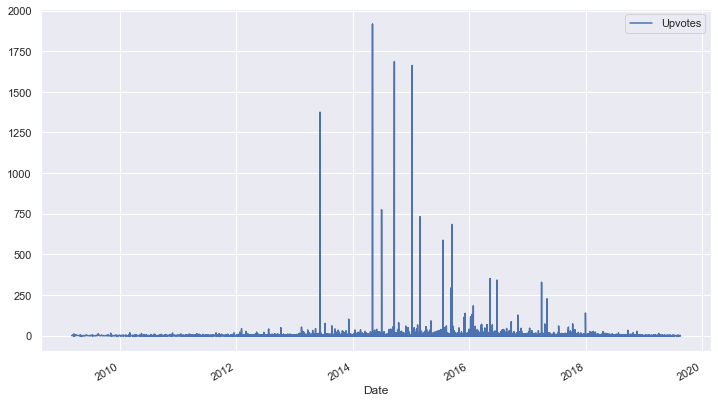

In [44]:
# Naively plot the number of upvotes in each date
df_by_time.plot(y='Upvotes', figsize=(12,7))

<AxesSubplot:xlabel='Date'>

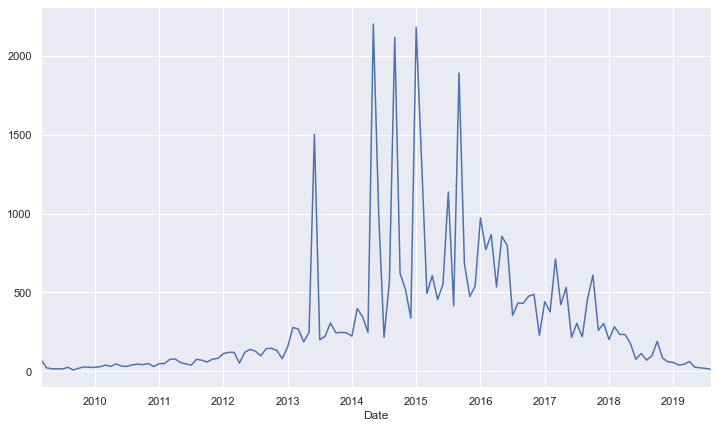

In [45]:
# Plot the number of upvotes in each month
df_by_time.groupby(df_by_time.index.to_period('M'))['Upvotes'].agg('sum').plot(figsize=(12,7))

<AxesSubplot:xlabel='Date'>

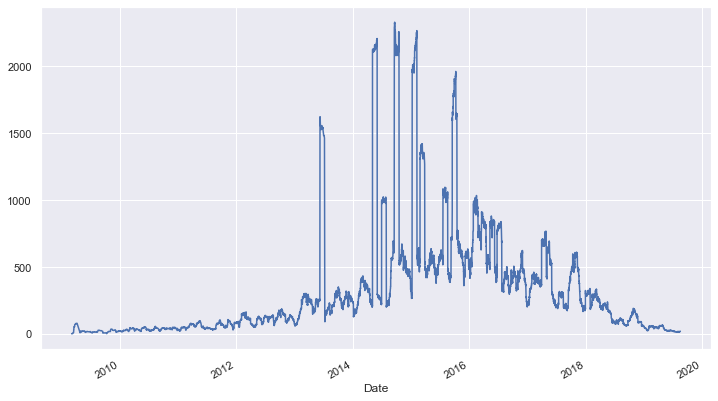

In [46]:
# Use rolling instead; this will produce a data point for each date instead of each month
df_by_time['Upvotes'].rolling('30D').agg('sum').plot(figsize=(12,7))

<AxesSubplot:xlabel='Company'>

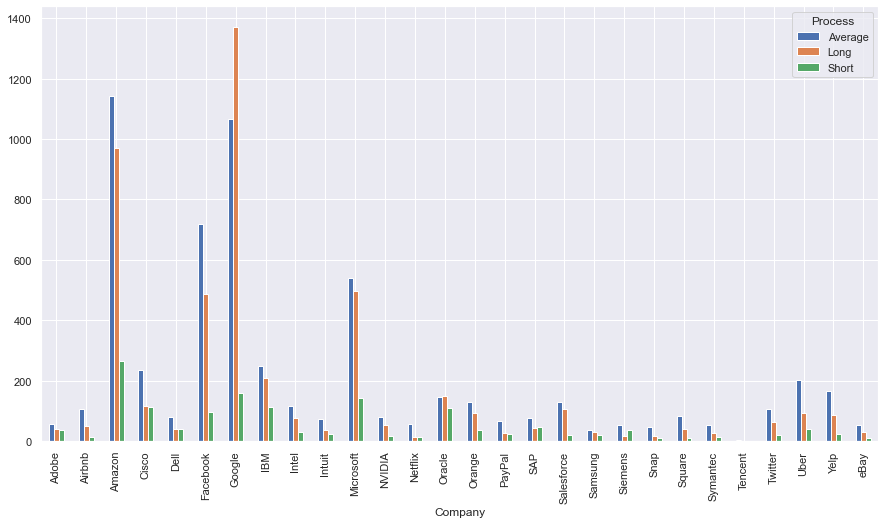

In [47]:
# Group the DataFrame by "Company" and "Process", count the number of elements,
# then unstack by "Process", then plot a bar chart
df.groupby(["Company", "Process"]).size().unstack(level=1).plot(kind="bar", figsize=(15, 8))

### 7.1 Produce Bokeh plots using the `pandas-bokeh` package

In [48]:
import pandas_bokeh
pandas_bokeh.output_notebook('jupyter')

Loading BokehJS ...

In [49]:
df.groupby(["Company", "Process"]).size().unstack(level=1).plot_bokeh(kind="bar", vertical_xlabel=True)

Figure(id='1039', ...)

## 8. GeoPandas

Working with geographical / geometric data? GeoPandas ([https://geopandas.org/en/stable/]()) is the tool for you!

To get started, go to [https://geopandas.org/en/stable/getting_started/introduction.html]() and learn the basics concepts of GeoPandas.
You can also take a look at the [gallery](https://geopandas.org/en/stable/gallery/index.html) to see some useful examples of how to use GeoPandas.

### Basic Concepts

A typical GeoDataFrame looks like this:
![GeoDataFrame](assets/geodataframe.png)

This is very similar to a regular dataframe, but a geodataframe also stores a special `geometry` column, which is a `GeoSeries`. Using this geometric column, we can perform a bunch of useful geometric operations efficiently.

Additionally, a `GeoDataFrame` or `GeoSeries` can store information about the projection of the geometry in the world. This information is stored in the attribute `.crs` (Coordinate Reference System).


In [50]:
import geopandas as gpd

path_to_data = gpd.datasets.get_path("nybb")
gdf = gpd.read_file(path_to_data).set_index("BoroName")

gdf

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [51]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
# Projecting onto different coordinate systems is easy!
gdf.to_crs('epsg:4326')

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


### 8.1 geometric operations (very similar to the ones offered by [shapely](https://shapely.readthedocs.io/en/stable/manual.html))

In [53]:
gdf['area'] = gdf.area
gdf['centroid'] = gdf.centroid
gdf['boundary'] = gdf.boundary
first_point = gdf.centroid.iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf[['area', 'centroid', 'boundary', 'distance']]

,area,centroid,boundary,distance
BoroName,,,,
Staten Island,1.623822e+09,POINT (941639.450 150931.991),"MULTILINESTRING ((970217.022 145643.332, 97022...",0.000000
Queens,3.045214e+09,POINT (1034578.078 197116.604),"MULTILINESTRING ((1029606.077 156073.814, 1029...",103781.535276
Brooklyn,1.937478e+09,POINT (998769.115 174169.761),"MULTILINESTRING ((1021176.479 151374.797, 1021...",61674.893421
Manhattan,6.364712e+08,POINT (993336.965 222451.437),"MULTILINESTRING ((981219.056 188655.316, 98094...",88247.742789
Bronx,1.186926e+09,POINT (1021174.790 249937.980),"MULTILINESTRING ((1012821.806 229228.265, 1012...",126996.283623


### 8.2 plotting maps

<AxesSubplot:>

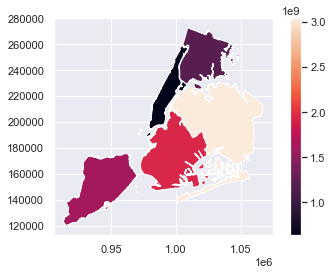

In [54]:
gdf.plot("area", legend=True)

In [55]:
gdf.explore("area", legend=False)

### 8.3 Spatial Joins

Just like regular relational joins and Pandas offers, GeoPandas allows us to join two geodataframes by using binary geometric predicates, such as intersection, touching, containment etc.

For example, let's merge two tables of countries and the cities inside them:

<AxesSubplot:>

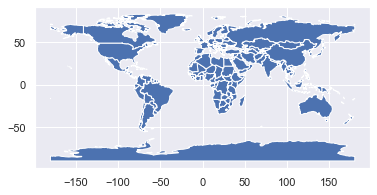

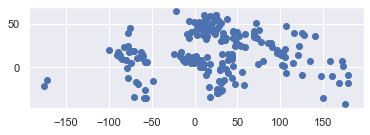

In [56]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
cities = gpd.read_file(gpd.datasets.get_path("naturalearth_cities"))
countries.plot()
cities.plot()

In [57]:
cities_w_country_data = cities.sjoin(countries)
cities_w_country_data.head()

,name_left,geometry,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),141,62137802,Europe,Italy,ITA,2221000.0
1,San Marino,POINT (12.44177 43.93610),141,62137802,Europe,Italy,ITA,2221000.0
192,Rome,POINT (12.48131 41.89790),141,62137802,Europe,Italy,ITA,2221000.0
2,Vaduz,POINT (9.51667 47.13372),114,8754413,Europe,Austria,AUT,416600.0
184,Vienna,POINT (16.36469 48.20196),114,8754413,Europe,Austria,AUT,416600.0


## Using pandas in your project

As you already know, using pandas is great. It will save you time and effort.
However, we don't see a lot of usage of dataframe objects inside our projects, compared to their popularity in exploratory notebooks. One of the reasons for this (in my opinion), is the difficulty of re-using a dataframe across different places in a project.

### Why using pandas in a project is hard

Essentially, passing a dataframe between different modules is bad because the receiver has no static information about the dataframe. What are the available columns? Are there other modules that use this data type? how?

Consider the following function:

In [58]:
import pandas as pd
from typing import List

def find_most_popular_people(friendships_df: pd.DataFrame) -> List[str]:
    """The most popular people are the top 5% with the most friends"""
    pass


The reader of this function has no idea what hides inside the `friendships_df` dataframe without actually running the code. It quickly becomes a nightmare to maintain, and very hard to make changes.

All of these questions are easily answered for most objects, as we can see how they are defined and where they are used with a single click in our IDE.

### DfWrapper: A proposal to overcome some of the difficulties

Seeing that pandas makes us much more efficient coders, we do not want to give up on it. Instead, I will propose a relatively simple design pattern that proved itself very helpful in some of my previous projects.
* Disclaimer: I do not think that what I am going to propose is the optimal solution - it probably isn't. But I do believe it is *_a_* solution, and it helped us a lot in a project that was full with tabular data.

**The basic idea**: wrap a raw dataframe object with a class, and assign a set of columns to that class. We will use `NamedTuples` to represent a df's columns, but dataclasses or dedicated object are fine as well - whatever works for you.


In [59]:
import pandas as pd
from typing import NamedTuple

class DfWrapper:
    cols: NamedTuple = None

    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        assert cls.cols is not None, f"You forgot to assign columns to class {cls.__name__}!"


Let's see how we can use this pattern to define a `FriendshipsDF` object, which will implement the desired `find_most_popular_people` function:

In [60]:
from typing import List

class FriendshipColumnNames(NamedTuple):
    person_a: str = 'person_a'
    person_b: str = 'person_b'
    friendship_length: str = 'friendship_length'

class FriendshipsDF(DfWrapper):
    cols = FriendshipColumnNames()

    def find_most_popular_people(self) -> List[str]:
        """The most popular people are the top 10% with the most friends"""
        bag_of_people = self.df[self.cols.person_a].append(self.df[self.cols.person_b])
        friendship_counts = bag_of_people.value_counts()
        most_popular_people = friendship_counts[friendship_counts >= friendship_counts.quantile(0.9)].index.tolist()
        return most_popular_people

That's it!

It might not seems like such a big help when viewing the enitre code in a few cells in the same notebook, but think about your own project where you once decided it would be a good idea to pass along a statically unstructured type such as a `dict`, and then tried to figure out what entries it should have or where it was created (`ExperimentData` anyone?)

# Summary

We have seen some cool stuff we can easily and effiently do with pandas. But there is so much more to learn - this package is HUGE.

My recommendation is that whenever you feel like something can be done in a pandas-y way, google it, and probably someone already did it. Slowly but surely you will be an expert yourself, and you will be able to implement seemingly complex operations quickly and with very few lines of code.

Happy coding :)
